Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", remove any ```raise NotImplementedError()``` and enter your student ID below:

STUDENT_ID = "170372134"

---

# MTH793P - Coursework 6

This is a template notebook for the computational exercises of Coursework 6 of the module MTH793P, Advanced machine learning. Closely follow the instructions in this template in order to complete the assessment and to obtain full marks. For the submitted notebook, please only modify cells where you are instructed to do so. Failure to comply may result in unexpected errors that can lead to mark deductions.

Author: [Nina Otter](mailto:n.otter@qmul.ac.uk)

Date: 02.11.2021

As usual, we begin by loading the necessary libraries.

In [13]:
%matplotlib inline
import numpy as np
from skimage.data import astronaut
from skimage import io as io1
from scipy import io as io2
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Singular value decomposition

First, we load the image of Eileen Collins and store it in a variable named *image*.

In [2]:
image = astronaut()

We visualise the image with the following cell.

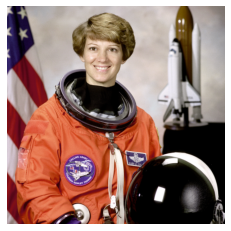

In [3]:
plt.imshow(image)
plt.axis('off') ;

Next, we store *image* as a matrix *matrix* of size $512 \times 1536$.

In [4]:
matrix = np.reshape(image,(512,1536))

Next, we compute the singular decomposition $\text{matrix} = U\Sigma V^\top$ of *matrix* and store the left singular vectors in the array *U*, the transpose of the right singular vectors in *V_transpose* and the singular values in *singular_values*...

In [5]:
U,singular_values,V_transpose = np.linalg.svd(matrix)

...and visualise the singular values (without and with logarithmic scaling).

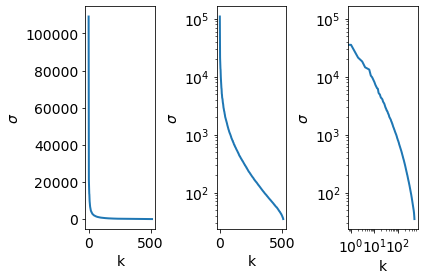

In [6]:
plt.subplot(1, 3, 1)
plt.plot(singular_values, linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1, 3, 2)
plt.semilogy(singular_values, linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1, 3, 3)
plt.plot(singular_values, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('singular-values.pdf')

Subsequently, we set all singular values after the index *index* to zero and print the ratio of the Frobenius norms of the approximation and the original matrix. The closer this ratio is to one, the better the approximation. Please experiment with different choices of *index*.

In [7]:
index = 150
print(np.sum([i**2 for i in singular_values[:index]])/np.sum([singular_values**2]))
print(np.sum([i for i in singular_values[:index]])/np.sum([singular_values]))

0.9991263319701399
0.8948655415226915


We visualise the cumulative sum of the singular values with the following cell.

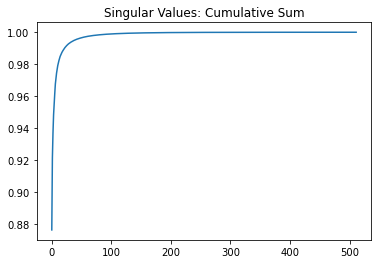

In [8]:
plt.plot(np.sqrt(np.cumsum(singular_values ** 2)/np.sum(singular_values ** 2)))
plt.title('Singular Values: Cumulative Sum')
plt.show()

We write a function **svd_thresholding** that takes an array *input_matrix* and a natural number *rank* as its input arguments and return the optimal approximation of *input_matrix* of rank *rank* in the sense of the Frobenius norm.

In [9]:
def svd_thresholding(input_matrix, rank):
    U,S,V_transpose = np.linalg.svd(input_matrix)
    S_matrix = np.diag(S)
    approximation_matrix = U[:,:rank] @ S_matrix[:rank,:rank] @ V_transpose[:rank,:]
    return approximation_matrix

Test your function *svd_thresholding* by applying it to the matrix *matrix* for different choices of *rank*, store at least one approximation in a variable named *matrix_approximation*, convert it to an image named *image_approximation* and visualise this image with suitable tools from the Matplotlib library.

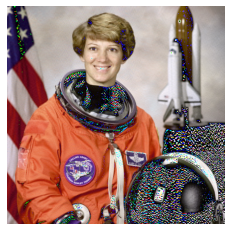

In [11]:
rank = 150
matrix_approximation = svd_thresholding(matrix,rank)
image_approximation = np.reshape(matrix_approximation,(512,512,-1))

plt.imshow(image_approximation.astype('uint8'));
plt.axis('off');

The following cells -- one visible, the other one hidden -- test your function with specific examples.

In [11]:
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(svd_thresholding(np.array([[3, 2, 2], [2, 3, -2]]), 1), np.array([[2.5, 2.5, 0], \
                                                                                         [2.5, 2.5, 0]]))

If you want to, you can save the images *image* and *image_approximations* to your hardrives with the following commands.

In [12]:
io1.imsave('svd-example-k-' + str(index) + '.png', np.rint(image_approximation).clip(0, 255).astype(np.uint8))
io1.imsave('astronaut.png', image)

We write two functions **standardise** and **de_standardise**. The first function should standardise the columns of the input argument *matrix* and return the standardised version together with the column-means and the column-standard-deviations. The second function inverts the operations of the first function. It takes arguments *matrix*, *means* and *stds* and multiplies *matrix* with the column-standard-deviations *stds* and adds back the column-means *means*.

In [11]:
def standardise(matrix):
    column_means = []
    column_sdvs = []    
    std_matrix = np.zeros((np.shape(matrix)))
    for i in range(np.shape(matrix)[1]):
        column_means.append(np.mean(matrix[:,i]))
        column_sdvs.append(np.std(matrix[:,i]))
        for j in range(np.shape(matrix)[0]):
            std_matrix[j,i] = (matrix[j,i]-column_means[i])/column_sdvs[i]
    return std_matrix , column_means, column_sdvs

def de_standardise(matrix, means, stds):
    dstd_matrix = np.zeros((np.shape(matrix)))
    for i in range(np.shape(matrix)[1]):
        for j in range(np.shape(matrix)[0]):
            dstd_matrix[j,i] = (matrix[j,i]*stds[i])+means[i]
    return dstd_matrix

We test both functions with four tests -- two visible, three hidden.

In [14]:
test_matrix = np.array([[5, 4, 1], [5, 5, 0], [0, 0, 5], [1, 0, 4]]).astype('float64')
std_matrix, means, stds = standardise(test_matrix)
assert_array_almost_equal(means, np.array([2.75, 2.25, 2.5]))

NameError: name 'assert_array_almost_equal' is not defined

In [15]:
assert_array_almost_equal(stds, np.array([2.27760839, 2.27760839, 2.06155281]))

NameError: name 'assert_array_almost_equal' is not defined

We repeat our previous experiment of computing the singular value decomposition, but standardise the matrix *matrix* first and store it in a variable named *matrix_standardised*. Store the corresponding singular values in a variable named *std_singular_values*.

In [16]:
matrix_standardised = standardise(matrix)[0]
std_singular_values = np.linalg.svd(matrix_standardised)[1]

As before, we visualise the decay of the singular values. 

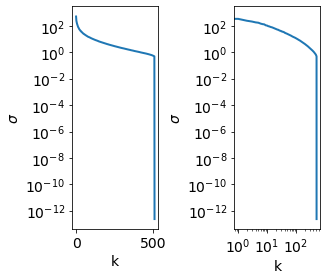

In [17]:
plt.subplot(3,1, 1)
plt.plot(std_singular_values, linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1, 3, 2)
plt.semilogy(std_singular_values, linewidth=2)
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(1, 3, 3)
plt.plot(std_singular_values, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout();

The behaviour is similar as before, but the range of the singular values has changed. We visualise the cumulative sum of the singular values and compare the cumulative sum with the non-standardised version.

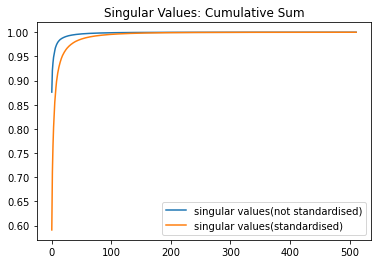

In [18]:
plt.plot(np.sqrt(np.cumsum(singular_values ** 2)/np.sum(singular_values ** 2)),label = 'singular values(not standardised)')
plt.plot(np.sqrt(np.cumsum(std_singular_values ** 2)/np.sum(std_singular_values ** 2)),label = 'singular values(standardised)')
plt.title('Singular Values: Cumulative Sum')
plt.legend()
plt.show()

Approximate the standardised matrix *matrix_standardised* with the optimal approximation of rank *rank* in the sense of the Frobenius norm and visualise your result. *Hint*: use the function *de_standardise* for this task.

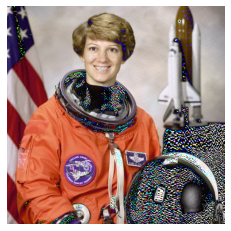

In [19]:
standardised_matrix_approximation = svd_thresholding(matrix_standardised,rank)
destandardised_matrix_approximation = de_standardise(standardised_matrix_approximation,standardise(matrix)[1],standardise(matrix)[2])

plt.imshow(np.reshape(destandardised_matrix_approximation,(512,512,-1)).astype('uint8'));
plt.axis('off');

## Eigenfaces

In the next part of this coursework, we work with a dataset consisting of numerous faces and create a basis of so-called eigenfaces. First, we update the sizes and fontsizes of the figures in this notebook. 

In [20]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams.update({'font.size': 16})

Now we load the Yale faces B mat-file *yale-b-faces.mat* with the help of scipy and store the data into the matrix *all_faces*. The dataset contains 2410 images of size $192 \times 168$ of 38 different people. The number of images per person is stored in the vector *number_of_faces_per_person*.

In [21]:
mat_file_import = io2.loadmat('yale-b-faces.mat')
all_faces = mat_file_import['faces']
number_of_faces_per_person = mat_file_import['nfaces'].reshape(-1)

We visualise a random selection of images from the Yale face B dataset with the following cell.

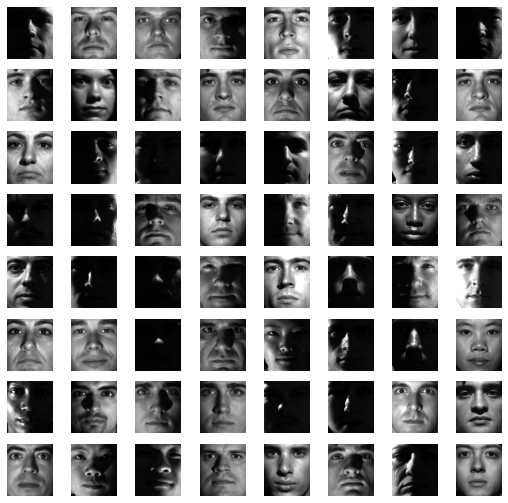

In [22]:
random_indices = np.random.permutation(all_faces.shape[1])
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(all_faces[:, random_indices[counter]].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout;

Next, we store all standardised face images of the first person in a data matrix *matrix*, the corresponding column-means in an array *means* and the column-standard-deviations in an array *stds*... 

In [23]:
m = []
means = []
stds = []
for counter in range(number_of_faces_per_person[0]):
    a = all_faces[:,counter].reshape((192, 168))
    m.append(standardise(a)[0].flatten())
    means.append(standardise(a)[1])
    stds.append(standardise(a)[2])
matrix = np.transpose(m)

...and visualise the faces via the following cell.

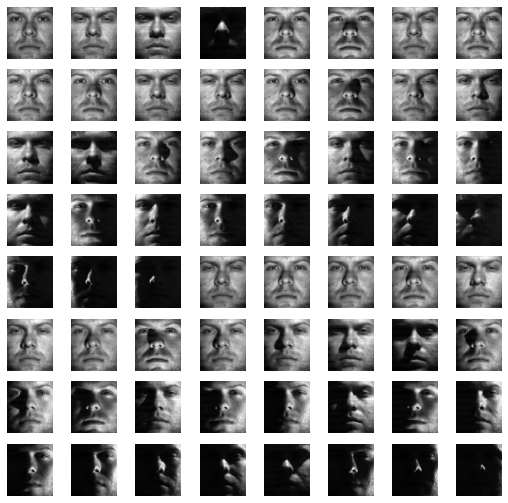

In [24]:
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout;

For our first task we compute the best rank-*approximation_index* approximation *approximated_matrix* of *matrix* in the sense of the Frobenius norm. Experiment with different choices of *approximation_index* and visualise your results.

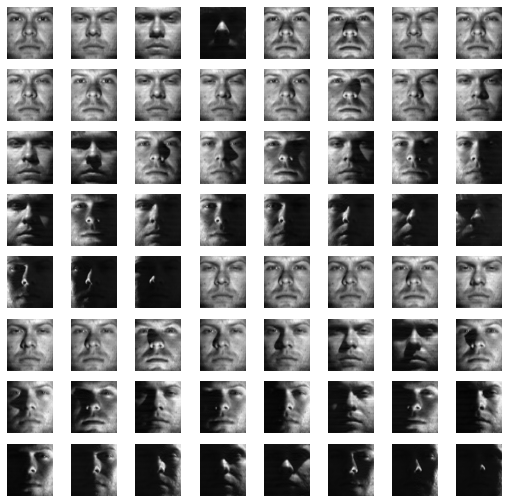

In [25]:
approximation_index = 29
a_m = []
for counter in range(number_of_faces_per_person[0]):
    a_m.append(svd_thresholding(matrix[:, counter].reshape((192, 168)),approximation_index).flatten())
approximated_matrix = np.transpose(a_m)

for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(approximated_matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout;

Test your result with the following hidden test for **approximation_index = 29**.

In [26]:
print("The error in Frobenius norm is {e}.".format(e = np.linalg.norm(approximated_matrix - matrix, 'fro')))

The error in Frobenius norm is 150.3667213071216.
